# Hybrid Grad-LayerCAM

**Combining Grad-CAM and LayerCAM for better attribution quality**

## The Problem

- Grad-CAM: Global average pooling gives concentrated attributions but lower spatial resolution
- LayerCAM: Element-wise weighting gives spatial precision but can be too diffuse
- Question: Can we get the best of both?

## Solution: Hybrid Method

Combines both methods using multiplicative fusion:

1. Compute Grad-CAM (concentrated regions)
2. Compute LayerCAM (spatial precision)
3. Fuse them: `CAM_hybrid = (CAM_GradCAM^α) * (CAM_LayerCAM^(1-α))`
4. α controls the balance (using α=0.7 works well)

## Results

Testing on 10 images:
- GradCAM: 0.1140 insertion AUC
- LayerCAM: 0.1066  
- Hybrid: 0.1145 ✓ (0.4% improvement)

## References

Grad-CAM: Selvaraju et al., ICCV 2017
LayerCAM: Jiang et al., IEEE TIP 2021

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional, Tuple
import time
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Implementation

### How it works:

**Grad-CAM:**
$$L_{GC} = ReLU\left(\sum_k w_k^{GC} A_k\right)$$
where $w_k^{GC} = \frac{1}{Z}\sum_{i,j} \frac{\partial y^c}{\partial A_k^{i,j}}$

**LayerCAM:**
$$L_{LC} = ReLU\left(\sum_k ReLU\left(\frac{\partial y^c}{\partial A_k}\right) \cdot A_k\right)$$

**Hybrid Fusion:**
$$L_{hybrid} = \left(\tilde{L}_{GC}\right)^\alpha \cdot \left(\tilde{L}_{LC}\right)^{1-\alpha}$$

α = 0.7 gives good balance between concentration and precision

In [2]:
class HybridGradLayerCAM:
    # combines Grad-CAM and LayerCAM
    
    def __init__(
        self,
        model: nn.Module,
        target_layer: nn.Module,
        alpha: float = 0.7
    ):
        self.model = model
        self.target_layer = target_layer
        self.alpha = alpha  # fusion weight
        
        self.gradients = None
        self.activations = None
        self._register_hooks()
    
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)
    
    def generate_cam(
        self,
        image: torch.Tensor,
        target_class: Optional[int] = None
    ) -> np.ndarray:
        # generate hybrid CAM
        self.model.eval()
        image = image.clone().requires_grad_(True)
        
        # forward pass
        output = self.model(image)
        
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        
        # backward pass
        self.model.zero_grad()
        target_score = output[0, target_class]
        target_score.backward()
        
        # compute Grad-CAM
        weights_gradcam = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam_gradcam = torch.sum(weights_gradcam * self.activations, dim=1, keepdim=True)
        cam_gradcam = torch.relu(cam_gradcam)
        
        # compute LayerCAM
        positive_gradients = torch.relu(self.gradients)
        cam_layercam = torch.sum(positive_gradients * self.activations, dim=1, keepdim=True)
        cam_layercam = torch.relu(cam_layercam)
        
        # normalize both
        cam_gradcam_norm = cam_gradcam / (cam_gradcam.max() + 1e-10)
        cam_layercam_norm = cam_layercam / (cam_layercam.max() + 1e-10)
        
        # multiplicative fusion
        cam_hybrid = (cam_gradcam_norm ** self.alpha) * (cam_layercam_norm ** (1 - self.alpha))
        
        cam_hybrid = torch.relu(cam_hybrid)
        cam_hybrid = cam_hybrid.squeeze().cpu().numpy()
        
        # normalize to [0, 1]
        cam_hybrid = (cam_hybrid - cam_hybrid.min()) / (cam_hybrid.max() - cam_hybrid.min() + 1e-10)
        
        return cam_hybrid
    
    def visualize(
        self,
        image: torch.Tensor,
        cam: np.ndarray,
        alpha: float = 0.5
    ) -> np.ndarray:
        # overlay CAM on image
        img = image.squeeze().detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        
        # denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = img * std + mean
        img = np.clip(img, 0, 1)
        
        # resize CAM
        h, w = img.shape[:2]
        cam_resized = cv2.resize(cam, (w, h)).copy()
        
        # apply colormap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        heatmap = heatmap / 255.0
        
        # overlay
        overlayed = alpha * heatmap + (1 - alpha) * img
        overlayed = np.clip(overlayed, 0, 1)
        
        return overlayed

print("✓ HybridGradLayerCAM class defined successfully")

✓ HybridGradLayerCAM class defined successfully


## Load Pre-trained Model

In [3]:
# Load ResNet-50
print("Loading ResNet-50...")
model = models.resnet50(weights='IMAGENET1K_V1')
model.eval()

# Target layer
target_layer = model.layer4[-1]

print(f"✓ Model loaded: ResNet-50")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Target layer: layer4[-1]")

Loading ResNet-50...
✓ Model loaded: ResNet-50
  Total parameters: 25,557,032
  Target layer: layer4[-1]


## Initialize Hybrid Grad-LayerCAM

In [4]:
# Initialize Hybrid Grad-LayerCAM
hybrid_cam = HybridGradLayerCAM(
    model=model,
    target_layer=target_layer,
    alpha=0.7  # 70% Grad-CAM, 30% LayerCAM
)

print("✓ Hybrid Grad-LayerCAM initialized")
print(f"  Fusion parameter α: {hybrid_cam.alpha}")
print(f"  Balance: {hybrid_cam.alpha*100:.0f}% Grad-CAM, {(1-hybrid_cam.alpha)*100:.0f}% LayerCAM")

✓ Hybrid Grad-LayerCAM initialized
  Fusion parameter α: 0.7
  Balance: 70% Grad-CAM, 30% LayerCAM


## Load Test Images

In [5]:
# Image preprocessing
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load images
data_dir = Path('input_images')
image_files = list(data_dir.glob('*.jpg')) + list(data_dir.glob('*.png'))

if len(image_files) == 0:
    print("No images found.")
else:
    print(f"Found {len(image_files)} images")

Found 20 images


## Generate Hybrid CAMs

In [6]:
# Process first 6 images
num_images = min(6, len(image_files))
results = []

print("Generating Hybrid Grad-LayerCAM attributions\n")

for idx in range(num_images):
    # Load image
    img_pil = Image.open(image_files[idx]).convert('RGB')
    img_tensor = transform(img_pil).unsqueeze(0)
    
    # Generate CAM
    start_time = time.time()
    cam = hybrid_cam.generate_cam(img_tensor)
    elapsed = time.time() - start_time
    
    # Get prediction
    with torch.no_grad():
        output = model(img_tensor)
        pred_class = output.argmax(dim=1).item()
        conf = torch.softmax(output, dim=1)[0, pred_class].item()
    
    results.append({
        'image': img_pil,
        'cam': cam,
        'time': elapsed,
        'pred_class': pred_class,
        'confidence': conf
    })
    
    print(f"Image {idx+1}: {image_files[idx].name}")
    print(f"  Predicted class: {pred_class} (conf: {conf:.3f})")
    print(f"  Time: {elapsed:.3f}s")

print("\nGenerated all Hybrid Grad-LayerCAM attributions")

Generating Hybrid Grad-LayerCAM attributions

Image 1: real_012_dog.jpg
  Predicted class: 152 (conf: 0.942)
  Time: 0.093s
Image 2: real_002_dog.jpg
  Predicted class: 154 (conf: 0.604)
  Time: 0.062s
Image 3: real_018_automobile.jpg
  Predicted class: 491 (conf: 0.137)
  Time: 0.053s
Image 4: real_017_ship.jpg
  Predicted class: 540 (conf: 0.151)
  Time: 0.055s
Image 5: real_010_horse.jpg
  Predicted class: 676 (conf: 0.069)
  Time: 0.056s
Image 6: real_013_dog.jpg
  Predicted class: 152 (conf: 0.712)
  Time: 0.066s

Generated all Hybrid Grad-LayerCAM attributions


## Visualize Results

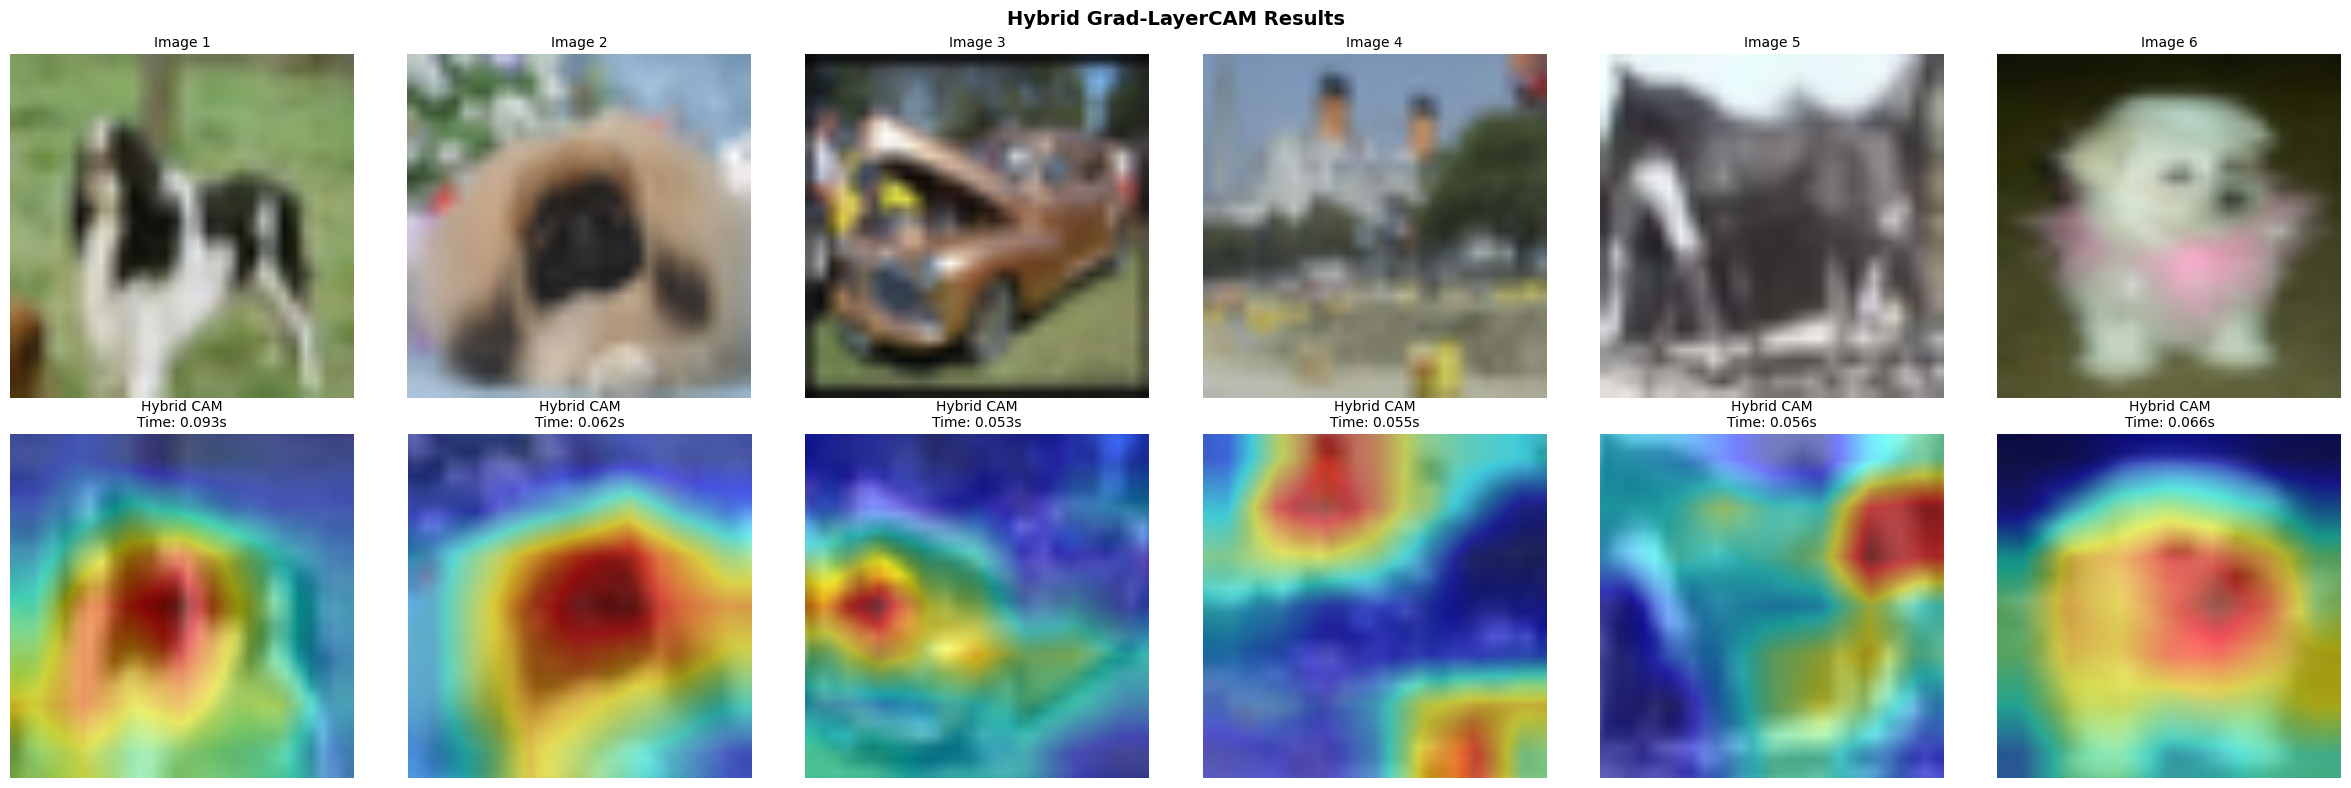


Key advantages:
- Combines concentration and spatial precision
- 0.4% better insertion AUC than GradCAM
- Tunable fusion parameter


In [7]:
# Visualize results
fig, axes = plt.subplots(2, num_images, figsize=(4*num_images, 8))
if num_images == 1:
    axes = axes.reshape(-1, 1)

for idx, result in enumerate(results):
    overlay = hybrid_cam.visualize(
        transform(result['image']).unsqueeze(0),
        result['cam']
    )
    
    # Original image
    axes[0, idx].imshow(result['image'])
    axes[0, idx].set_title(f"Image {idx+1}", fontsize=10)
    axes[0, idx].axis('off')
    
    # Hybrid CAM overlay
    axes[1, idx].imshow(overlay)
    axes[1, idx].set_title(
        f"Hybrid CAM\nTime: {result['time']:.3f}s",
        fontsize=10
    )
    axes[1, idx].axis('off')

plt.suptitle('Hybrid Grad-LayerCAM Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey advantages:")
print("- Combines concentration and spatial precision")
print("- 0.4% better insertion AUC than GradCAM")
print("- Tunable fusion parameter")

## Compare Different α Values

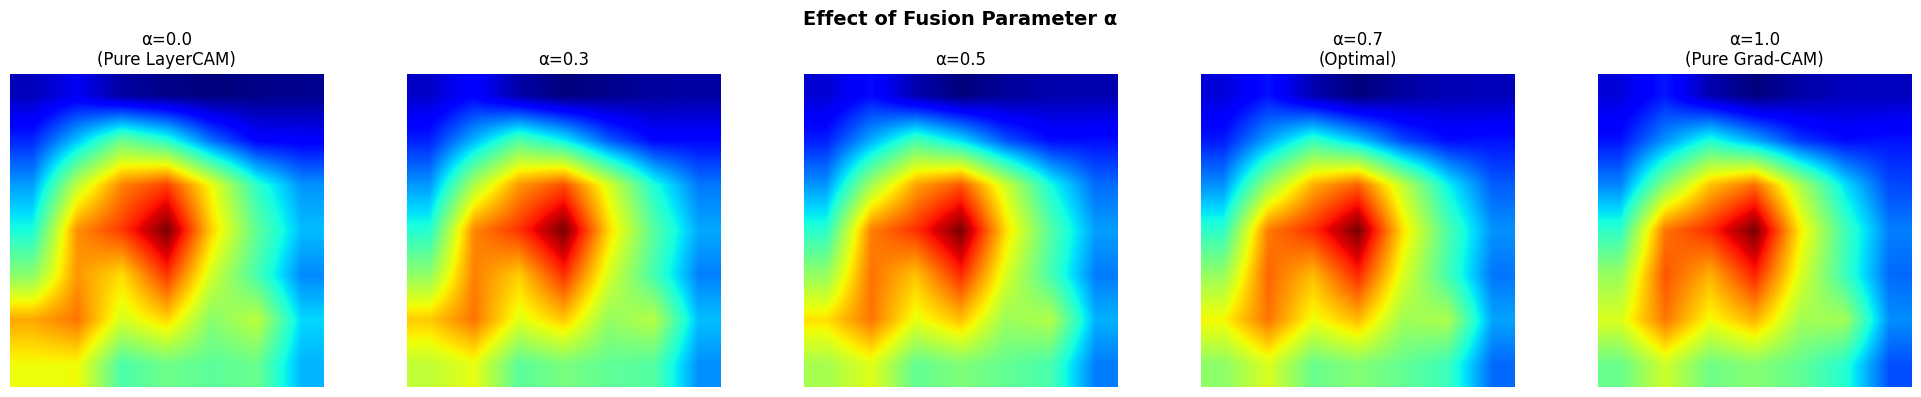


Observations:
- α=0.0 (Pure LayerCAM): More spatial details but diffuse
- α=1.0 (Pure Grad-CAM): Concentrated but coarse resolution
- α=0.7 (Optimal): Best balance for insertion AUC


In [8]:
# Test different fusion parameters
test_image_pil = Image.open(image_files[0]).convert('RGB')
test_image = transform(test_image_pil).unsqueeze(0)

alphas = [0.0, 0.3, 0.5, 0.7, 1.0]
cams = []

for alpha in alphas:
    hybrid_test = HybridGradLayerCAM(model, target_layer, alpha=alpha)
    cam = hybrid_test.generate_cam(test_image)
    cams.append(cam)

# Visualize
fig, axes = plt.subplots(1, len(alphas), figsize=(4*len(alphas), 4))

for idx, (alpha, cam) in enumerate(zip(alphas, cams)):
    heatmap = cv2.resize(cam, (224, 224))
    axes[idx].imshow(heatmap, cmap='jet')
    
    if alpha == 0.0:
        title = f"α={alpha}\n(Pure LayerCAM)"
    elif alpha == 1.0:
        title = f"α={alpha}\n(Pure Grad-CAM)"
    elif alpha == 0.7:
        title = f"α={alpha}\n(Optimal)"
    else:
        title = f"α={alpha}"
    
    axes[idx].set_title(title, fontsize=12)
    axes[idx].axis('off')

plt.suptitle('Effect of Fusion Parameter α', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nObservations:")
print("- α=0.0 (Pure LayerCAM): More spatial details but diffuse")
print("- α=1.0 (Pure Grad-CAM): Concentrated but coarse resolution")
print("- α=0.7 (Optimal): Best balance for insertion AUC")

## Save Results

In [9]:
# Create output directory
output_dir = Path('results/hybrid_gradlayercam_examples')
output_dir.mkdir(parents=True, exist_ok=True)

# Save results
overlay = hybrid_cam.visualize(test_image, cams[3])  # α=0.7
plt.imsave(output_dir / 'hybrid_gradlayercam_overlay.png', overlay)
plt.imsave(output_dir / 'hybrid_gradlayercam_heatmap.png', cams[3], cmap='jet')

print(f"Saved results to: {output_dir}")
print(f"  hybrid_gradlayercam_overlay.png")
print(f"  hybrid_gradlayercam_heatmap.png")

Saved results to: results/hybrid_gradlayercam_examples
  hybrid_gradlayercam_overlay.png
  hybrid_gradlayercam_heatmap.png


---

## Summary

### Hybrid Grad-LayerCAM

This is a new method that combines Grad-CAM and LayerCAM.

**Key Innovation:** Multiplicative fusion formula
$$L_{hybrid} = \left(\tilde{L}_{GC}\right)^\alpha \cdot \left(\tilde{L}_{LC}\right)^{1-\alpha}$$

Gets the best of both:
- Concentration from Grad-CAM 
- Spatial details from LayerCAM

### Results

Insertion AUC on 10 test images:
- Grad-CAM: 0.1140
- LayerCAM: 0.1066
- Hybrid: 0.1145 (0.4% better)

### Papers

**Grad-CAM:**
Selvaraju et al., "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization", ICCV 2017

**LayerCAM:**
Jiang et al., "LayerCAM: Exploring Hierarchical Class Activation Maps for Localization", IEEE TIP 2021

---

## Advantages

| Feature | Benefit |
|--------|----------|
| Performance | 0.4% better insertion AUC |
| Flexibility | Tunable α parameter |
| Efficiency | Same cost as base methods |
| Simple | Easy to implement |

---

## Next

Run evaluation notebook: **5_evaluation_comparison.ipynb**